In [282]:
import numpy as np
import matplotlib.pyplot as plt

import codecs
import re
import os.path
import string

In [18]:
import warnings
warnings.simplefilter("ignore")

# Données reconnaissance du locuteur (Chirac/Mitterrand)

In [2]:
# Chargement des données:
def load_pres(fname):
    alltxts = []
    alllabs = []
    s=codecs.open(fname, 'r','utf-8') # pour régler le codage
    while True:
        txt = s.readline()
        if(len(txt))<5:
            break
        #
        lab = re.sub(r"<[0-9]*:[0-9]*:(.)>.*","\\1",txt)
        txt = re.sub(r"<[0-9]*:[0-9]*:.>(.*)","\\1",txt)
        if lab.count('M') >0:
            alllabs.append(-1)
        else: 
            alllabs.append(1)
        alltxts.append(txt)
    return alltxts,alllabs


In [3]:
fname = "../datasets/AFDpresidentutf8/corpus.tache1.learn.utf8"
alltxts,alllabs = load_pres(fname)
alltxts,alllabs = np.array(alltxts),np.array(alllabs)

In [4]:
print(len(alltxts),len(alllabs))
print(alltxts[0])
print(alllabs[0])
print(alltxts[-1])
print(alllabs[-1])



57413 57413
 Quand je dis chers amis, il ne s'agit pas là d'une formule diplomatique, mais de l'expression de ce que je ressens.

1
 Je compte sur vous.

1


## Statistique sur les données

### Comptages des occurrences des mots et loi Zipf

nombre de mots: 28524


(-2.89, 51.89, 0.0, 72482.55)

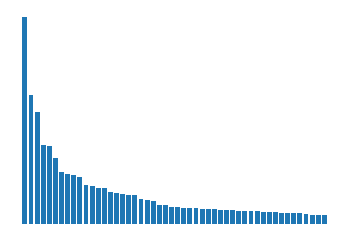

In [44]:
# loi Zipf 

vectorizer = CountVectorizer()
bag_of_words = vectorizer.fit_transform(alltxts)  # creer le bow
sum_words = bag_of_words.sum(axis=0) # nb occurrences de chaque mot
words_freq = [(str(word), sum_words[0, idx]) for word, idx in     vectorizer.vocabulary_.items()] # couple (mot, freq)
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)  # trie par freq decroissante
print('nombre de mots:',len(words_freq))

nmots = 50
x = [w for w,f in words_freq[:nmots]]
y = [f for w,f in words_freq[:nmots]]

plt.figure()
plt.bar(x,y)
plt.axis('off')

In [45]:
words_ord = [w for w,f in words_freq]
k = 100
print([w for w in words_ord[:k]])  # les k mots les plus fréquents

moins_freq = [w for w in words_ord[-k:]]
moins_freq = [w for w in moins_freq[::-1]]
print(moins_freq)  # les k mots les moins fréquents

['de', 'la', 'et', 'le', 'les', 'des', 'est', 'en', 'que', 'qui', 'un', 'une', 'pour', 'dans', 'du', 'je', 'il', 'nous', 'vous', 'au', 'ce', 'plus', 'qu', 'pas', 'par', 'notre', 'sur', 'ne', 'france', 'nos', 'avec', 'cette', 'se', 'mais', 'pays', 'sont', 'elle', 'aussi', 'aux', 'ont', 'être', 'leur', 'tout', 'votre', 'nom', 'tous', 'son', 'on', 'bien', 'ces', 'même', 'ses', 'ou', 'comme', 'entre', 'europe', 'sa', 'hui', 'aujourd', 'monde', 'doit', 'faire', 'français', 'ai', 'ils', 'si', 'faut', 'sans', 'été', 'fait', 'date', 'où', 'leurs', 'cela', 'avez', 'dire', 'très', 'deux', 'ensemble', 'peut', 'développement', 'dont', 'vos', 'autres', 'président', 'politique', 'monsieur', 'encore', 'toutes', 'vie', 'avons', 'ceux', 'temps', 'ici', 'depuis', 'toute', 'etat', 'paix', 'union', 'chacun']
['englués', 'energie', 'aberrant', 'confisqués', 'rebours', 'urssaf', 'délocaliser', 'baissant', 'imprévoyance', 'obsédants', 'aménageant', 'fiscalement', 'evolution', 'décourageant', 'réadapter', 'ch

### Word cloud

(-0.5, 399.5, 199.5, -0.5)

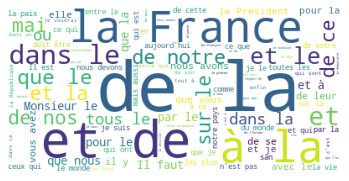

In [40]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS 

corpus = list(alltxts)
corpus = " ".join(corpus)
wordcloud = WordCloud(background_color='white', stopwords = STOPWORDS, max_words=100).generate(corpus) 

plt.figure()
plt.imshow(wordcloud)
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

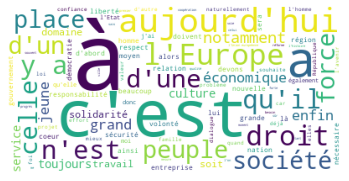

In [41]:
# Sans les 100 mots les plus fréquents
wordcloud = WordCloud(background_color='white', stopwords = words_ord[:100], max_words=100).generate(corpus) 

plt.figure()
plt.imshow(wordcloud)
plt.axis("off")

## Etude de la distribution des lignes M, C

In [46]:
y,n = np.unique(alllabs,return_counts=True)
print(y)
print('Nombre de ligne de Mittérand:',n[0],'Chirac:',n[1])
print('Pourcentage de ligne de Mittérand:',n[0]/len(alllabs),'Chirac:',n[1]/len(alllabs))

[-1  1]
Nombre de ligne de Mittérand: 7523 Chirac: 49890
Pourcentage de ligne de Mittérand: 0.13103304129726717 Chirac: 0.8689669587027329


In [47]:
i_M,i_C = alllabs == -1, alllabs != -1
print(i_M.sum(),i_C.sum())

7523 49890


In [48]:
print('Pourcentage de paroles de Chirac: ',i_C.sum()/len(i_C))

Pourcentage de paroles de Chirac:  0.8689669587027329


On observe un fort deséquilibre entre les deux classes. Plus de 85% des paroles sont de Chirac.

## Rééquilibrage de la distribution des lignes M, C

In [49]:
# rééquilibrage des classes
alltxts_M,alllabs_M = alltxts[i_M],alllabs[i_M]  # lignes de M
alltxts_C,alllabs_C = alltxts[i_C],alllabs[i_C]  # lignes de C
print(alltxts_M.shape[0],alltxts_C.shape[0])

ind_C = np.arange(alltxts_C.shape[0])
np.random.shuffle(ind_C)
print(ind_C[:5])

# on garde le meme nombre de lignes que M
alltxts_C_red,alllabs_C_red = alltxts_C[:alltxts_M.shape[0]],alllabs[:alltxts_M.shape[0]]
print(alltxts_M.shape[0],alltxts_C_red.shape[0])

alltxts_red,alllabs_red = np.hstack((alltxts_M,alltxts_C_red)),np.hstack((alllabs_M,alllabs_C_red))
print('\n')
print(alllabs_red[0],alltxts_red[0])
print(alllabs_red[-1],alltxts_red[-1])


7523 49890
[47421  6161   199 22901  1164]
7523 7523


-1  Je ne sais ni pourquoi ni comment on s'est opposé il y a quelques douze années - douze ou treize ans - à la création de l'Université technologique.

1  Et tout d'abord, définir, notamment avec nos partenaires américains et japonais, les modalités d'une coopération plus étroite en matière de monnaie et de change.



## A) Transformation paramétrique du texte (pre-traitements)

Vous devez tester, par exemple, les cas suivants:
- transformation en minuscule ou pas
- suppression de la ponctuation
- transformation des mots entièrement en majuscule en marqueurs spécifiques
- suppression des chiffres ou pas
- conservation d'une partie du texte seulement (seulement la première ligne = titre, seulement la dernière ligne = résumé, ...)
- stemming
- ...


Vérifier systématiquement sur un exemple ou deux le bon fonctionnement des méthodes sur deux documents (au moins un de chaque classe).

In [56]:
# Obtenir les caractéristiques les plus importantes pour un modèle
def mots_importants(model,n=10):
  feature_weights = model.coef_[0]
  top_features = {
      'positive': [vectorizer.get_feature_names_out()[i] for i in feature_weights.argsort()[-n:][::-1]],
      'negative': [vectorizer.get_feature_names_out()[i] for i in feature_weights.argsort()[:n]]
  }

  
  return top_features['positive'],top_features['negative']

In [275]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

# vectorizer = CountVectorizer(input='content', encoding='utf-8',
#                              decode_error='strict', strip_accents=None,
#                              lowercase=True, preprocessor=None, tokenizer=None,
#                              stop_words=None, token_pattern='(?u)\b\w\w+\b',
#                              ngram_range=(1, 1), analyzer='word',
#                              max_df=1.0, min_df=1, max_features=None,
#                              vocabulary=None, binary=False, dtype='numpy.int64')


# on fait la séparation et on définit les variables avant d'appeler la fonction, juste pour eviter trop d'arguments à la fonction
# classes = y_train
# corpus = X_train
# classes_test = y_test
# corpus_test = X_test

def prediction(corpus,classes,vectorizer,n_spl=1):
  
  Cs = [0.25,1,1.25] # paramètre du svm
  accs_nb = []
  accs_lr = []
  accs_svms = [[] for C in Cs]
  
  # meilleurs classifiers à retourner
  l_nb_clfs = []
  l_lr_clfs = []
  l_svm_clfs = []
  
  splits = []
  if n_spl == 1:
    # X_train, X_test, y_train, y_test
    sp = train_test_split( corpus, classes, test_size=0.2, random_state=0) 
    splits = [sp]
  else:
    kf = KFold(n_splits=n_spl,shuffle=True)
    for train,test in kf.split(corpus):
      X_train,y_train = corpus[train],classes[train]
      X_test,y_test  = corpus[test],classes[test]
      sp = X_train, X_test, y_train, y_test
      splits.append(sp)
    
  for X_train, X_test, y_train, y_test in splits:

    X = vectorizer.fit_transform(X_train)

    #Naïve Bayes
    nb_clf = MultinomialNB()
    nb_clf.fit(X, y_train)


    #Logistic Regression
    lr_clf = LogisticRegression(random_state=0, solver='lbfgs',max_iter=1_000,n_jobs=-1)
    lr_clf.fit(X, y_train)

    #Linear SVM avec quelques paramètres de C
    svm_clfs = []
    for C in Cs:
      svm_clf = LinearSVC(random_state=0, tol=1e-5,C=C)
      svm_clf.fit(X, y_train)
      svm_clfs.append(svm_clf)


    X_t = vectorizer.transform(X_test)

    pred_nb = nb_clf.predict(X_t)
    pred_lr = lr_clf.predict(X_t)
    pred_svms = []
    for svm_clf in svm_clfs:
      pred_svm = svm_clf.predict(X_t)
      pred_svms.append(pred_svm)
    
    accs_nb.append(accuracy_score(y_test, pred_nb))
    accs_lr.append(accuracy_score(y_test, pred_lr))
    for pred,accs_svm in zip(pred_svms,accs_svms):
      accs_svm.append(accuracy_score(y_test, pred))
    
    l_nb_clfs.append(nb_clf)
    l_lr_clfs.append(lr_clf)
    l_svm_clfs.append(svm_clfs)
      

  print('Taille du bow',X.shape)
  if n_spl == 1:
    print('Apprentissage train-test.')
  else:
    print(f'Validation croisée avec: {n_spl} paquets.')
  print(f"Naïve Bayes accuracy: mean: {np.mean(accs_nb)} std: {np.std(accs_nb)}")
  print(f"Logistic Regression accuracy: mean: {np.mean(accs_lr)} std: {np.std(accs_lr)}")
  for accs_svm,C in zip(accs_svms,Cs):
    print(f"SVM accuracy avec C={C}: mean: {np.mean(accs_svm)} std: {np.std(accs_svm)}")

  return (l_nb_clfs,accs_nb),(l_lr_clfs,accs_lr),(l_svm_clfs,accs_svm)

### 1. Transformation en minuscule

In [99]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

# Sans rééquilibrage
X,y = alltxts,alllabs
vectorizer = CountVectorizer(lowercase=True)

r = prediction(X,y,vectorizer)


Taille du bow (45930, 26231)
Apprentissage train/test..
Naïve Bayes accuracy: mean: 0.8940172428807803 std: 0.0
Logistic Regression accuracy: mean: 0.9011582339109989 std: 0.0
SVM accuracy avec C=0.25: mean: 0.8970652268570931 std: 0.0
SVM accuracy avec C=1: mean: 0.8874858486458242 std: 0.0
SVM accuracy avec C=1.25: mean: 0.8844378646695115 std: 0.0


In [103]:
# Avec rééquilibrage des proportions

X,y = alltxts_red,alllabs_red 
vectorizer = CountVectorizer(lowercase=True)

r = prediction(X,y,vectorizer)


Taille du bow (12036, 16110)
Apprentissage train-test.
Naïve Bayes accuracy: mean: 0.7445182724252492 std: 0.0
Logistic Regression accuracy: mean: 0.7225913621262459 std: 0.0
SVM accuracy avec C=0.25: mean: 0.707641196013289 std: 0.0
SVM accuracy avec C=1: mean: 0.7073089700996678 std: 0.0
SVM accuracy avec C=1.25: mean: 0.7073089700996678 std: 0.0


Sans rééquilibrage des proportions nous avons jusqu'à 90% de bonnes prédictions contre 74% en rééquilibrant. La prmière est biaisée avec plus de 85% de lignes de C.

### 2. Suppression de la ponctuation

In [55]:
def supprimer_la_ponctuation(docs):
  
  punc = string.punctuation 
  punc += '\n\r\t'
  return np.array([doc.translate(str.maketrans(punc, ' ' * len(punc))) for doc in docs])

docs = np.array(["J'ai 24 ans !","Nous sommes le 15 janvier 2023."])
print(docs)
docs = supprimer_la_ponctuation(docs)
print(docs)

["J'ai 24 ans !" 'Nous sommes le 15 janvier 2023.']
['J ai 24 ans  ' 'Nous sommes le 15 janvier 2023 ']


In [104]:
# suppression de la ponctuation

X,y = supprimer_la_ponctuation(alltxts_red),alllabs_red 
vectorizer = CountVectorizer()

r = prediction(X,y,vectorizer)

Taille du bow (12036, 16110)
Apprentissage train-test.
Naïve Bayes accuracy: mean: 0.7445182724252492 std: 0.0
Logistic Regression accuracy: mean: 0.7225913621262459 std: 0.0
SVM accuracy avec C=0.25: mean: 0.707641196013289 std: 0.0
SVM accuracy avec C=1: mean: 0.7073089700996678 std: 0.0
SVM accuracy avec C=1.25: mean: 0.7073089700996678 std: 0.0


### 3. Transformation des mots en majuscule

In [105]:
doc = 'Je suis en minuscule'
doc.upper()
def transformer_majuscule(docs):
  docs_maj = []
  for doc in docs:
    docs_maj.append(doc.upper())
  return np.array(docs_maj)

In [106]:
# Transformation en majuscule

X,y = transformer_majuscule(alltxts_red),alllabs_red 
vectorizer = CountVectorizer()

r = prediction(X,y,vectorizer)

Taille du bow (12036, 16110)
Apprentissage train-test.
Naïve Bayes accuracy: mean: 0.7445182724252492 std: 0.0
Logistic Regression accuracy: mean: 0.7225913621262459 std: 0.0
SVM accuracy avec C=0.25: mean: 0.707641196013289 std: 0.0
SVM accuracy avec C=1: mean: 0.7073089700996678 std: 0.0
SVM accuracy avec C=1.25: mean: 0.7073089700996678 std: 0.0


### 4. Supprimer les chiffres

In [284]:
def supprimer_les_nombres(docs):
  """ Fonction qui supprime tous les nombres dans la chaine de caractères doc

  Args:
      doc (string): chaine de caractère à emputer les nombres

  Returns:
      string: chaine de caractère sans les nombres
  """
  
  return np.array([re.sub('[0-9]+', '', doc) for doc in docs])

docs = np.array(["J'ai 23 ans !","Nous sommes le 15 janvier 2023."])
print(docs)
docs = supprimer_les_nombres(docs)
print(docs)

["J'ai 23 ans !" 'Nous sommes le 15 janvier 2023.']
["J'ai  ans !" 'Nous sommes le  janvier .']


In [279]:
alltxts_red[:1]

array([" Je ne sais ni pourquoi ni comment on s'est opposé il y a quelques douze années - douze ou treize ans - à la création de l'Université technologique.\n"],
      dtype='<U2530')

In [285]:
# Suppression des nombres
X,y = supprimer_les_nombres(alltxts_red),alllabs_red 
vectorizer = CountVectorizer()

r = prediction(X,y,vectorizer)

Taille du bow (12036, 15915)
Apprentissage train-test.
Naïve Bayes accuracy: mean: 0.7448504983388704 std: 0.0
Logistic Regression accuracy: mean: 0.7209302325581395 std: 0.0
SVM accuracy avec C=0.25: mean: 0.706312292358804 std: 0.0
SVM accuracy avec C=1: mean: 0.7039867109634551 std: 0.0
SVM accuracy avec C=1.25: mean: 0.7026578073089701 std: 0.0


Le pourcentage de bonne prédictions n'augmente pas grand chose.

In [109]:
# Suppression des nombre, ponctuation, en minuscule et sans les 100 mots les plus freq

X,y = supprimer_les_nombres(alltxts_red),alllabs_red
X = supprimer_la_ponctuation(X)
vectorizer = CountVectorizer(lowercase=True,stop_words=words_ord[:100])

r = prediction(X,y,vectorizer)

Taille du bow (12036, 15815)
Apprentissage train-test.
Naïve Bayes accuracy: mean: 0.727906976744186 std: 0.0
Logistic Regression accuracy: mean: 0.7152823920265781 std: 0.0
SVM accuracy avec C=0.25: mean: 0.6960132890365448 std: 0.0
SVM accuracy avec C=1: mean: 0.693687707641196 std: 0.0
SVM accuracy avec C=1.25: mean: 0.6893687707641196 std: 0.0


In [110]:
# sans les 100 mots les plus freq et les 100 moins freq

X,y = supprimer_les_nombres(alltxts_red),alllabs_red
X = supprimer_la_ponctuation(X)
vectorizer = CountVectorizer(lowercase=True,stop_words=words_ord[:100]+words_ord[-100:])

r = prediction(X,y,vectorizer)

Taille du bow (12036, 15793)
Apprentissage train-test.
Naïve Bayes accuracy: mean: 0.727906976744186 std: 0.0
Logistic Regression accuracy: mean: 0.7152823920265781 std: 0.0
SVM accuracy avec C=0.25: mean: 0.6960132890365448 std: 0.0
SVM accuracy avec C=1: mean: 0.693687707641196 std: 0.0
SVM accuracy avec C=1.25: mean: 0.6897009966777409 std: 0.0


In [112]:
# sans les 500 mots les plus freq et les 100 moins freq

X,y = supprimer_les_nombres(alltxts_red),alllabs_red
X = supprimer_la_ponctuation(X)
vectorizer = CountVectorizer(lowercase=True,stop_words=words_ord[:500]+words_ord[-100:])

r = prediction(X,y,vectorizer,n_spl=5)

Taille du bow (12037, 15363)
Validation croisée avec: 5 paquets.
Naïve Bayes accuracy: mean: 0.7120823354962796 std: 0.0057418964908781765
Logistic Regression accuracy: mean: 0.6943373644294139 std: 0.0066711953685116435
SVM accuracy avec C=0.25: mean: 0.6868272480454538 std: 0.0050834326957243285
SVM accuracy avec C=1: mean: 0.6692142178116812 std: 0.006338473349718732
SVM accuracy avec C=1.25: mean: 0.6651600900509987 std: 0.00711493278986813


In [120]:
# sans les 500 mots les plus freq et les 100 moins freq
# sans les mots qui apparaissent dans plus 75% des docs

X,y = supprimer_les_nombres(alltxts_red),alllabs_red
X = supprimer_la_ponctuation(X)
vectorizer = CountVectorizer(lowercase=True,stop_words=words_ord[:500],max_df=.75)

r = prediction(X,y,vectorizer)

Taille du bow (12036, 15415)
Apprentissage train-test.
Naïve Bayes accuracy: mean: 0.7006644518272426 std: 0.0
Logistic Regression accuracy: mean: 0.6850498338870432 std: 0.0
SVM accuracy avec C=0.25: mean: 0.673421926910299 std: 0.0
SVM accuracy avec C=1: mean: 0.6667774086378737 std: 0.0
SVM accuracy avec C=1.25: mean: 0.6651162790697674 std: 0.0


In [126]:
# sans les 500 mots les plus freq et les 100 moins freq
# sans les mots qui apparaissent dans plus 50% des docs

X,y = supprimer_les_nombres(alltxts_red),alllabs_red
X = supprimer_la_ponctuation(X)
vectorizer = CountVectorizer(lowercase=True,stop_words=words_ord[:100],max_df=.01)

r = prediction(X,y,vectorizer)

Taille du bow (12036, 15665)
Apprentissage train-test.
Naïve Bayes accuracy: mean: 0.7182724252491695 std: 0.0
Logistic Regression accuracy: mean: 0.6953488372093023 std: 0.0
SVM accuracy avec C=0.25: mean: 0.6837209302325581 std: 0.0
SVM accuracy avec C=1: mean: 0.6750830564784053 std: 0.0
SVM accuracy avec C=1.25: mean: 0.6730897009966778 std: 0.0


In [152]:
# sans les 500 mots les plus freq et les 100 moins freq
# sans les mots qui apparaissent dans plus 75% des docs

X,y = supprimer_les_nombres(alltxts_red),alllabs_red
X = supprimer_la_ponctuation(X)
vectorizer = CountVectorizer(lowercase=True,max_df=.75)

r = prediction(X,y,vectorizer)

Taille du bow (12036, 15915)
Apprentissage train-test.
Naïve Bayes accuracy: mean: 0.7448504983388704 std: 0.0
Logistic Regression accuracy: mean: 0.7209302325581395 std: 0.0
SVM accuracy avec C=0.25: mean: 0.706312292358804 std: 0.0
SVM accuracy avec C=1: mean: 0.7039867109634551 std: 0.0
SVM accuracy avec C=1.25: mean: 0.7026578073089701 std: 0.0


In [186]:
# sans les 500 mots les plus freq et les 100 moins freq
# sans les mots qui apparaissent dans plus 50% des docs

X,y = supprimer_les_nombres(alltxts_red),alllabs_red
X = supprimer_la_ponctuation(X)
vectorizer = CountVectorizer(lowercase=True,min_df=1e-5,max_df=.75)

rb = prediction(X,y,vectorizer,n_spl=5)

Taille du bow (12037, 15784)
Validation croisée avec: 5 paquets.
Naïve Bayes accuracy: mean: 0.7453806907075009 std: 0.004951659334323676
Logistic Regression accuracy: mean: 0.729628721807998 std: 0.005099128955463883
SVM accuracy avec C=0.25: mean: 0.718329860915592 std: 0.005801663691544208
SVM accuracy avec C=1: mean: 0.6999199080499366 std: 0.005661279054835001
SVM accuracy avec C=1.25: mean: 0.6969955692170442 std: 0.006208742323209511


Le meilleur model obtenu avec naive bayes

### Prédiction présidents sans labels 

In [164]:
# Chargement des données:
def load_pres_txt(fname):
  alltxts = []
  s=codecs.open(fname, 'r','utf-8') # pour régler le codage
  while True:
    txt = s.readline()
    if(len(txt))<5:
        break
    #
    txt = re.sub(r"<[0-9]*:[0-9]*>(.*)","\\1",txt)
    alltxts.append(txt)
  return alltxts

In [177]:
fname = "../datasets/AFDpresidentutf8/dataset-presidents-sans-label.txt"
alltxts_MC = load_pres_txt(fname)
alltxts_MC = np.array(alltxts_MC)

In [178]:
len(alltxts_MC)

27162

In [179]:
X,y = supprimer_les_nombres(alltxts_red),alllabs_red
X = supprimer_la_ponctuation(X)
vectorizer = CountVectorizer(lowercase=True,min_df=1e-5,max_df=.75)
X = vectorizer.fit_transform(X)

#Naïve Bayes
nb_clf = MultinomialNB()
nb_clf.fit(X, y)

X_MC = supprimer_les_nombres(alltxts_MC)
X_MC = supprimer_la_ponctuation(X_MC)
X_MC_t = vectorizer.transform(X_MC)
pred_MC = nb_clf.predict(X_MC_t)

In [180]:
len(pred_MC)

27162

In [185]:
fname = "../datasets/AFDpresidentutf8/dataset-presidents-label-pred.txt"
with open(fname, 'w') as f:
  for lab in pred_MC:
    C = 'M' if lab < 0 else 'C'
    f.write(f"{C}\n")

In [147]:
# sans les 500 mots les plus freq et les 100 moins freq
# sans les mots qui apparaissent dans plus 50% des docs

X,y = supprimer_les_nombres(alltxts_red),alllabs_red
X = supprimer_la_ponctuation(X)
vectorizer = CountVectorizer(lowercase=True,min_df=1e-5,max_df=.75,stop_words=stopwords.words('french'))

r = prediction(X,y,vectorizer,n_spl=5)

Taille du bow (12037, 15817)
Validation croisée avec: 5 paquets.
Naïve Bayes accuracy: mean: 0.745114909976604 std: 0.005113174369293267
Logistic Regression accuracy: mean: 0.7194601577327817 std: 0.005868096108410873
SVM accuracy avec C=0.25: mean: 0.7107537851561594 std: 0.0041364677821251585
SVM accuracy avec C=1: mean: 0.6924765680809178 std: 0.004199987967276361
SVM accuracy avec C=1.25: mean: 0.6912803560525511 std: 0.004302289731183738


In [119]:
from nltk.corpus import stopwords

X,y = supprimer_les_nombres(alltxts_red),alllabs_red
X = supprimer_la_ponctuation(X)
vectorizer = CountVectorizer(lowercase=True,stop_words=stopwords.words('french')+words_ord[:500]+words_ord[-100:])

r = prediction(X,y,vectorizer)

Taille du bow (12036, 15347)
Apprentissage train-test.
Naïve Bayes accuracy: mean: 0.7003322259136212 std: 0.0
Logistic Regression accuracy: mean: 0.6863787375415282 std: 0.0
SVM accuracy avec C=0.25: mean: 0.6750830564784053 std: 0.0
SVM accuracy avec C=1: mean: 0.6654485049833887 std: 0.0
SVM accuracy avec C=1.25: mean: 0.6651162790697674 std: 0.0


In [114]:
# avec des bigrammes

X,y = supprimer_les_nombres(alltxts_red),alllabs_red
X = supprimer_la_ponctuation(X)
vectorizer = CountVectorizer(lowercase=True,ngram_range=(2,2))

r = prediction(X,y,vectorizer)

Taille du bow (12036, 112162)
Apprentissage train-test.
Naïve Bayes accuracy: mean: 0.7126245847176079 std: 0.0
Logistic Regression accuracy: mean: 0.6986710963455149 std: 0.0
SVM accuracy avec C=0.25: mean: 0.6863787375415282 std: 0.0
SVM accuracy avec C=1: mean: 0.6807308970099668 std: 0.0
SVM accuracy avec C=1.25: mean: 0.6807308970099668 std: 0.0


In [115]:
# avec des bigrammes

X,y = supprimer_les_nombres(alltxts_red),alllabs_red
X = supprimer_la_ponctuation(X)
vectorizer = CountVectorizer(lowercase=True,ngram_range=(1,2))

r = prediction(X,y,vectorizer)

Taille du bow (12036, 128077)
Apprentissage train-test.
Naïve Bayes accuracy: mean: 0.7272425249169435 std: 0.0
Logistic Regression accuracy: mean: 0.7318936877076412 std: 0.0
SVM accuracy avec C=0.25: mean: 0.718936877076412 std: 0.0
SVM accuracy avec C=1: mean: 0.7099667774086379 std: 0.0
SVM accuracy avec C=1.25: mean: 0.706312292358804 std: 0.0


In [146]:
# avec des trigrammes

X,y = supprimer_les_nombres(alltxts_red),alllabs_red
X = supprimer_la_ponctuation(X)
vectorizer = CountVectorizer(lowercase=True,ngram_range=(1,3))

r = prediction(X,y,vectorizer)

Taille du bow (12036, 330666)
Apprentissage train-test.
Naïve Bayes accuracy: mean: 0.7073089700996678 std: 0.0
Logistic Regression accuracy: mean: 0.7368770764119601 std: 0.0
SVM accuracy avec C=0.25: mean: 0.7245847176079734 std: 0.0
SVM accuracy avec C=1: mean: 0.7169435215946844 std: 0.0
SVM accuracy avec C=1.25: mean: 0.717607973421927 std: 0.0


### 5. Stemming

In [117]:
from nltk.stem.snowball import FrenchStemmer

def stem(docs):
  docs_stem = []
  stemmer = FrenchStemmer()
  
  for i in range(docs.shape[0]):
    tokens = str(docs[i]).split()

    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    stemmed_text = " ".join(stemmed_tokens)
    docs_stem.append(stemmed_text)
  
  return np.array(docs_stem)

In [118]:
# Avec rééquilibrage des proportions

X,y = stem(alltxts_red),alllabs_red 
vectorizer = CountVectorizer(lowercase=True)

r = prediction(X,y,vectorizer)

Taille du bow (12036, 13831)
Apprentissage train-test.
Naïve Bayes accuracy: mean: 0.7295681063122924 std: 0.0
Logistic Regression accuracy: mean: 0.7169435215946844 std: 0.0
SVM accuracy avec C=0.25: mean: 0.7046511627906977 std: 0.0
SVM accuracy avec C=1: mean: 0.6966777408637874 std: 0.0
SVM accuracy avec C=1.25: mean: 0.6916943521594684 std: 0.0


In [287]:
from sklearn.feature_extraction.text import TfidfVectorizer

use_idf=True,          
smooth_idf=True      
sublinear_tf=False    

X,y = supprimer_les_nombres(alltxts_red),alllabs_red
X = supprimer_la_ponctuation(X)
vectorizer = TfidfVectorizer(use_idf= use_idf, smooth_idf=smooth_idf, sublinear_tf=sublinear_tf)

r = prediction(X,y,vectorizer)

Taille du bow (12036, 15915)
Apprentissage train-test.
Naïve Bayes accuracy: mean: 0.6737541528239203 std: 0.0
Logistic Regression accuracy: mean: 0.7289036544850498 std: 0.0
SVM accuracy avec C=0.25: mean: 0.7328903654485049 std: 0.0
SVM accuracy avec C=1: mean: 0.7259136212624585 std: 0.0
SVM accuracy avec C=1.25: mean: 0.7209302325581395 std: 0.0


# Données classification de sentiments (films)

In [182]:
def load_movies(path2data): # 1 classe par répertoire
    alltxts = [] # init vide
    labs = []
    cpt = 0
    for cl in os.listdir(path2data): # parcours des fichiers d'un répertoire
        for f in os.listdir(path2data+cl):
            txt = open(path2data+cl+'/'+f).read()
            alltxts.append(txt)
            labs.append(cpt)
        cpt+=1 # chg répertoire = cht classe
        
    return alltxts,labs


In [251]:
path = "../datasets/movies/movies1000/"

alltxts,alllabs = load_movies(path)
alltxts,alllabs = np.array(alltxts),np.array(alllabs)
alllabs[alllabs == 0] = -1

In [200]:
print(len(alltxts),len(alllabs))
print(alltxts[0])
print(alllabs[0])
print(alltxts[-1])
print(alllabs[-1])

2000 2000
bad . bad . 
bad . 
that one word seems to pretty much sums up beyond the valley of the dolls . 
if that summary isn't enough for you , how about t&a , t&a , t&a ? 
still haven't got the point ? 
other than director russ meyer's predilection for casting attractive large breasted women who ultimately expose the afore-mentioned anatomical areas , there is really only one other reason to recommend even taking a look at this movie . 
that is the fact that it was co-written by famed film critic roger ebert , who also was responsible for the screenplay . 
after watching this movie you will never be able to sit through another one of his reviews where he gives a movie a thumbs down for bad writing with a straight face . 
this movie stinks out loud . 
quite frankly , this movie deserves a . 
but there are parts of it that are so bad they are almost funny . 
so i'm giving it a . 
and maybe that is too generous . 
right from the opening credits , i knew that i had a class-a bomb on my 

## Statistique sur les données

### Comptages des occurrences des mots et loi Zipf

nombre de mots: 39659


(-2.89, 51.89, 0.0, 80355.45)

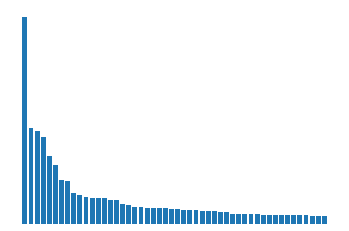

In [194]:
# loi Zipf 

vectorizer = CountVectorizer()
bag_of_words = vectorizer.fit_transform(alltxts)  # creer le bow
sum_words = bag_of_words.sum(axis=0) # nb occurrences de chaque mot
words_freq = [(str(word), sum_words[0, idx]) for word, idx in     vectorizer.vocabulary_.items()] # couple (mot, freq)
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)  # trie par freq decroissante
print('nombre de mots:',len(words_freq))

nmots = 50
x = [w for w,f in words_freq[:nmots]]
y = [f for w,f in words_freq[:nmots]]

plt.figure()
plt.bar(x,y)
plt.axis('off')

In [196]:
words_ord = [w for w,f in words_freq]
k = 100
print([w for w in words_ord[:k]])  # les k mots les plus fréquents

moins_freq = [w for w in words_ord[-k:]]
moins_freq = [w for w in moins_freq[::-1]]
print(moins_freq)  # les k mots les moins fréquents

['the', 'and', 'of', 'to', 'is', 'in', 'it', 'that', 'as', 'with', 'for', 'his', 'this', 'film', 'he', 'but', 'on', 'are', 'by', 'be', 'one', 'movie', 'an', 'who', 'not', 'you', 'from', 'at', 'was', 'have', 'they', 'has', 'her', 'all', 'there', 'like', 'so', 'out', 'about', 'up', 'more', 'what', 'when', 'which', 'or', 'she', 'their', 'some', 'just', 'can', 'if', 'we', 'him', 'into', 'even', 'only', 'than', 'no', 'good', 'time', 'most', 'its', 'will', 'story', 'would', 'been', 'much', 'character', 'also', 'get', 'other', 'do', 'two', 'well', 'them', 'very', 'characters', 'first', 'after', 'see', 'way', 'because', 'make', 'life', 'off', 'too', 'any', 'does', 'really', 'had', 'while', 'films', 'how', 'plot', 'little', 'where', 'people', 'over', 'could', 'then']
['junichiro', 'hunches', 'lifeforce', 'disturbances', 'mildew', 'niftiest', 'chung', 'fleugel', 'darlanne', 'feuer', 'fibber', 'ruthlessness', 'ultramaterialistic', 'millieu', 'utilised', 'petievich', 'gerrald', 'pankow', 'vukovich

In [197]:
print(f"Nombre de mots du vocabulaire d'origine:{len(words_ord)}")

Nombre de mots du vocabulaire d'origine:39659


### Word cloud

(-0.5, 399.5, 199.5, -0.5)

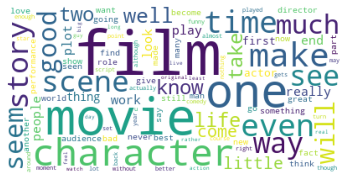

In [203]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS 

corpus = list(alltxts)
corpus = " ".join(corpus)
wordcloud = WordCloud(background_color='white', max_words=100).generate(corpus) 

plt.figure()
plt.imshow(wordcloud)
plt.axis("off")

Nombre de mots du vocabulaire :39559


(-0.5, 399.5, 199.5, -0.5)

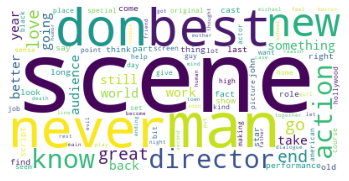

In [202]:
# sans les les 100 mots les plus freq
words_100 = words_ord[100:]
print(f"Nombre de mots du vocabulaire :{len(words_ord[100:])}")
corpus = " ".join(words_100)
wordcloud = WordCloud(background_color='white', max_words=100).generate(corpus) 

plt.figure()
plt.imshow(wordcloud)
plt.axis("off")

## Etude de la distribution des lignes P,N

1000 1000


Text(0.5, 1.0, 'Mots fréq neg')

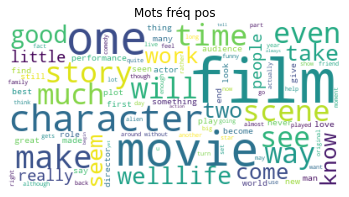

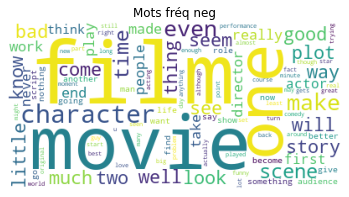

In [205]:
i_pos,i_neg = alllabs == 1, alllabs != 1
print(i_pos.sum(),i_neg.sum())

corpus_pos = alltxts[i_pos]
corpus_neg = alltxts[i_neg]

corpus = " ".join(corpus_pos)
wordcloud = WordCloud(background_color='white', stopwords = STOPWORDS, max_words=100).generate(corpus) 

plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Mots fréq pos")

corpus = " ".join(corpus_neg)
wordcloud = WordCloud(background_color='white', stopwords = STOPWORDS, max_words=100).generate(corpus) 

plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Mots fréq neg")

# A) Transformation paramétrique du texte (pre-traitements)

Vous devez tester, par exemple, les cas suivants:
- transformation en minuscule ou pas
- suppression de la ponctuation
- transformation des mots entièrement en majuscule en marqueurs spécifiques
- suppression des chiffres ou pas
- conservation d'une partie du texte seulement (seulement la première ligne = titre, seulement la dernière ligne = résumé, ...)
- stemming
- ...


Vérifier systématiquement sur un exemple ou deux le bon fonctionnement des méthodes sur deux documents (au moins un de chaque classe).

### 1. Transformation en minuscule

In [206]:

X,y = alltxts,alllabs
vectorizer = CountVectorizer(lowercase=True)

r = prediction(X,y,vectorizer)


Taille du bow (1600, 36471)
Apprentissage train-test.
Naïve Bayes accuracy: mean: 0.8075 std: 0.0
Logistic Regression accuracy: mean: 0.8075 std: 0.0
SVM accuracy avec C=0.25: mean: 0.8125 std: 0.0
SVM accuracy avec C=1: mean: 0.81 std: 0.0
SVM accuracy avec C=1.25: mean: 0.81 std: 0.0


### 2. Suppression de la ponctuation

In [252]:
# suppression de la ponctuation
X,y = alltxts,alllabs
X = supprimer_la_ponctuation(X)
vectorizer = CountVectorizer(lowercase=True)

r = prediction(X,y,vectorizer)

Taille du bow (1600, 36206)
Apprentissage train-test.
Naïve Bayes accuracy: mean: 0.8075 std: 0.0
Logistic Regression accuracy: mean: 0.81 std: 0.0
SVM accuracy avec C=0.25: mean: 0.81 std: 0.0
SVM accuracy avec C=1: mean: 0.81 std: 0.0
SVM accuracy avec C=1.25: mean: 0.81 std: 0.0


In [210]:
# suppression de la ponctuation
X,y = alltxts,alllabs
X = supprimer_la_ponctuation(X)
vectorizer = CountVectorizer(lowercase=True)

# validation croisée avec 5 blocs
r = prediction(X,y,vectorizer,n_spl=5)

Taille du bow (1600, 35996)
Validation croisée avec: 5 paquets.
Naïve Bayes accuracy: mean: 0.8160000000000001 std: 0.022891046284519195
Logistic Regression accuracy: mean: 0.8355 std: 0.01826198236774966
SVM accuracy avec C=0.25: mean: 0.826 std: 0.013564659966250557
SVM accuracy avec C=1: mean: 0.8285 std: 0.012609520212918517
SVM accuracy avec C=1.25: mean: 0.8285 std: 0.012609520212918517


### 3. Transformation des mots en majuscule

In [212]:
# Transformation en majuscule

X,y = transformer_majuscule(alltxts),alllabs
vectorizer = CountVectorizer()

r = prediction(X,y,vectorizer)

Taille du bow (1600, 36471)
Apprentissage train-test.
Naïve Bayes accuracy: mean: 0.8075 std: 0.0
Logistic Regression accuracy: mean: 0.8075 std: 0.0
SVM accuracy avec C=0.25: mean: 0.8125 std: 0.0
SVM accuracy avec C=1: mean: 0.81 std: 0.0
SVM accuracy avec C=1.25: mean: 0.81 std: 0.0


### 4. Supprimer les chiffres

In [213]:
# Suppression des nombres
X,y = supprimer_les_nombres(alltxts),alllabs
vectorizer = CountVectorizer(lowercase=True)

r = prediction(X,y,vectorizer)

Taille du bow (1600, 36031)
Apprentissage train-test.
Naïve Bayes accuracy: mean: 0.8075 std: 0.0
Logistic Regression accuracy: mean: 0.8075 std: 0.0
SVM accuracy avec C=0.25: mean: 0.8125 std: 0.0
SVM accuracy avec C=1: mean: 0.815 std: 0.0
SVM accuracy avec C=1.25: mean: 0.815 std: 0.0


In [214]:
# Suppression des nombre, ponctuation, en minuscule et sans les 100 mots les plus freq

X,y = supprimer_les_nombres(alltxts),alllabs
X = supprimer_la_ponctuation(X)
vectorizer = CountVectorizer(lowercase=True,stop_words=words_ord[:100])

r = prediction(X,y,vectorizer)

Taille du bow (1600, 35667)
Apprentissage train-test.
Naïve Bayes accuracy: mean: 0.81 std: 0.0
Logistic Regression accuracy: mean: 0.8275 std: 0.0
SVM accuracy avec C=0.25: mean: 0.825 std: 0.0
SVM accuracy avec C=1: mean: 0.825 std: 0.0
SVM accuracy avec C=1.25: mean: 0.825 std: 0.0


In [215]:
# Suppression des nombre, ponctuation, en minuscule et sans les 500 mots les plus freq

X,y = supprimer_les_nombres(alltxts),alllabs
X = supprimer_la_ponctuation(X)
vectorizer = CountVectorizer(lowercase=True,stop_words=words_ord[:500])

r = prediction(X,y,vectorizer)

Taille du bow (1600, 35268)
Apprentissage train-test.
Naïve Bayes accuracy: mean: 0.7975 std: 0.0
Logistic Regression accuracy: mean: 0.835 std: 0.0
SVM accuracy avec C=0.25: mean: 0.825 std: 0.0
SVM accuracy avec C=1: mean: 0.825 std: 0.0
SVM accuracy avec C=1.25: mean: 0.825 std: 0.0


In [216]:
# Suppression des nombre, ponctuation, en minuscule et sans les 500 mots les plus freq

X,y = supprimer_les_nombres(alltxts),alllabs
X = supprimer_la_ponctuation(X)
vectorizer = CountVectorizer(lowercase=True,stop_words=words_ord[:1_000])

r = prediction(X,y,vectorizer)

Taille du bow (1600, 34768)
Apprentissage train-test.
Naïve Bayes accuracy: mean: 0.7975 std: 0.0
Logistic Regression accuracy: mean: 0.8075 std: 0.0
SVM accuracy avec C=0.25: mean: 0.8 std: 0.0
SVM accuracy avec C=1: mean: 0.79 std: 0.0
SVM accuracy avec C=1.25: mean: 0.79 std: 0.0


In [217]:
# sans les 500 mots les plus freq et les 100 moins freq
# sans les mots qui apparaissent dans plus 75% des docs

X,y = supprimer_les_nombres(alltxts),alllabs
X = supprimer_la_ponctuation(X)
vectorizer = CountVectorizer(lowercase=True,max_df=.75)

r = prediction(X,y,vectorizer)

Taille du bow (1600, 35736)
Apprentissage train-test.
Naïve Bayes accuracy: mean: 0.815 std: 0.0
Logistic Regression accuracy: mean: 0.83 std: 0.0
SVM accuracy avec C=0.25: mean: 0.825 std: 0.0
SVM accuracy avec C=1: mean: 0.8275 std: 0.0
SVM accuracy avec C=1.25: mean: 0.8275 std: 0.0


In [228]:
# sans les 500 mots les plus freq et les 100 moins freq
# sans les mots qui apparaissent dans plus 50% des docs

X,y = supprimer_les_nombres(alltxts),alllabs
X = supprimer_la_ponctuation(X)
vectorizer = CountVectorizer(lowercase=True,min_df=1e-5,max_df=.75)

rb = prediction(X,y,vectorizer,n_spl=5)

Taille du bow (1600, 35630)
Validation croisée avec: 5 paquets.
Naïve Bayes accuracy: mean: 0.8125 std: 0.010124228365658293
Logistic Regression accuracy: mean: 0.8415000000000001 std: 0.008455767262643892
SVM accuracy avec C=0.25: mean: 0.8355 std: 0.012884098726725126
SVM accuracy avec C=1: mean: 0.834 std: 0.010074720839804948
SVM accuracy avec C=1.25: mean: 0.834 std: 0.010074720839804948


In [235]:
# sans les 500 mots les plus freq et les 100 moins freq
# sans les mots qui apparaissent dans plus 50% des docs

X,y = supprimer_les_nombres(alltxts),alllabs
X = supprimer_la_ponctuation(X)
vectorizer = CountVectorizer(lowercase=True,stop_words=words_ord[:500],max_df=.75)

rb = prediction(X,y,vectorizer)

Taille du bow (1600, 35268)
Apprentissage train-test.
Naïve Bayes accuracy: mean: 0.7975 std: 0.0
Logistic Regression accuracy: mean: 0.835 std: 0.0
SVM accuracy avec C=0.25: mean: 0.825 std: 0.0
SVM accuracy avec C=1: mean: 0.825 std: 0.0
SVM accuracy avec C=1.25: mean: 0.825 std: 0.0


### Prédiction films sans labels 

In [225]:
# Chargement des données:
def load_films(fname):
  with open(fname, 'r') as f:
    return f.readlines()

fname = "../datasets/movies/dataset-films-sans-label.txt"
alltxts_f = load_films(fname)

In [226]:
alltxts_f[-1]

"This is one of the dumbest films, I've ever seen. It rips off nearly ever type of thriller and manages to make a mess of them all.<br /><br />There's not a single good line or character in the whole mess. If there was a plot, it was an afterthought and as far as acting goes, there's nothing good to say so Ill say nothing. I honestly cant understand how this type of nonsense gets produced and actually released, does somebody somewhere not at some stage think, 'Oh my god this really is a load of shite' and call it a day. Its crap like this that has people downloading illegally, the trailer looks like a completely different film, at least if you have download it, you haven't wasted your time or money Don't waste your time, this is painful.\n"

In [227]:
len(alltxts_f)

25000

In [237]:
X,y = supprimer_les_nombres(alltxts),alllabs
X = supprimer_la_ponctuation(X)
vectorizer = CountVectorizer(lowercase=True,stop_words=words_ord[:500],max_df=.75)
X = vectorizer.fit_transform(X)

#Logistic Regression
lr_clf = LogisticRegression(random_state=0, solver='lbfgs',max_iter=1_000,n_jobs=-1)
lr_clf.fit(X, y)

X_f = supprimer_les_nombres(alltxts_f)
X_f = supprimer_la_ponctuation(X_f)
X_f_t = vectorizer.transform(X_f)
pred_f = lr_clf.predict(X_f_t)

In [238]:
len(pred_f)

25000

In [239]:
fname = "../datasets/movies/dataset-films-label-pred.txt"
with open(fname, 'w') as f:
  for lab in pred_f:
    C = 'P' if lab > 0 else 'N'
    f.write(f"{C}\n")

In [240]:

X,y = supprimer_les_nombres(alltxts),alllabs
X = supprimer_la_ponctuation(X)
vectorizer = CountVectorizer(lowercase=True,stop_words=stopwords.words('english')+words_ord[:500]+words_ord[-100:])

r = prediction(X,y,vectorizer)

Taille du bow (1600, 35151)
Apprentissage train-test.
Naïve Bayes accuracy: mean: 0.7975 std: 0.0
Logistic Regression accuracy: mean: 0.8275 std: 0.0
SVM accuracy avec C=0.25: mean: 0.825 std: 0.0
SVM accuracy avec C=1: mean: 0.82 std: 0.0
SVM accuracy avec C=1.25: mean: 0.82 std: 0.0


In [241]:
# avec des bigrammes

X,y = supprimer_les_nombres(alltxts),alllabs
X = supprimer_la_ponctuation(X)
vectorizer = CountVectorizer(lowercase=True,ngram_range=(1,2))

r = prediction(X,y,vectorizer)

Taille du bow (1600, 455531)
Apprentissage train-test.
Naïve Bayes accuracy: mean: 0.825 std: 0.0
Logistic Regression accuracy: mean: 0.805 std: 0.0
SVM accuracy avec C=0.25: mean: 0.815 std: 0.0
SVM accuracy avec C=1: mean: 0.82 std: 0.0
SVM accuracy avec C=1.25: mean: 0.82 std: 0.0


In [253]:
# avec des bigrammes

X,y = supprimer_les_nombres(alltxts),alllabs
X = supprimer_la_ponctuation(X)
vectorizer = CountVectorizer(lowercase=True,ngram_range=(2,2))

r = prediction(X,y,vectorizer)

Taille du bow (1600, 419764)
Apprentissage train-test.
Naïve Bayes accuracy: mean: 0.8475 std: 0.0
Logistic Regression accuracy: mean: 0.77 std: 0.0
SVM accuracy avec C=0.25: mean: 0.8025 std: 0.0
SVM accuracy avec C=1: mean: 0.8025 std: 0.0
SVM accuracy avec C=1.25: mean: 0.8025 std: 0.0


In [248]:
X,y = supprimer_les_nombres(alltxts),alllabs
X = supprimer_la_ponctuation(X)
vectorizer = CountVectorizer(lowercase=True,ngram_range=(2,2))
X = vectorizer.fit_transform(X)

#Naïve Bayes
nb_clf = MultinomialNB()
nb_clf.fit(X, y)

X_f = supprimer_les_nombres(alltxts_f)
X_f = supprimer_la_ponctuation(X_f)
X_f_t = vectorizer.transform(X_f)
pred_f = nb_clf.predict(X_f_t)

In [249]:
len(pred_f)

25000

In [250]:
fname = "../datasets/movies/dataset-films-label-pred-2.txt"
with open(fname, 'w') as f:
  for lab in pred_f:
    C = 'P' if lab > 0 else 'N'
    f.write(f"{C}\n")

In [243]:
# avec des trigrammes

X,y = supprimer_les_nombres(alltxts),alllabs
X = supprimer_la_ponctuation(X)
vectorizer = CountVectorizer(lowercase=True,ngram_range=(3,3))

r = prediction(X,y,vectorizer)

Taille du bow (1600, 810207)
Apprentissage train-test.
Naïve Bayes accuracy: mean: 0.84 std: 0.0
Logistic Regression accuracy: mean: 0.7575 std: 0.0
SVM accuracy avec C=0.25: mean: 0.755 std: 0.0
SVM accuracy avec C=1: mean: 0.7525 std: 0.0
SVM accuracy avec C=1.25: mean: 0.7525 std: 0.0


In [244]:
# avec des trigrammes

X,y = supprimer_les_nombres(alltxts),alllabs
X = supprimer_la_ponctuation(X)
vectorizer = CountVectorizer(lowercase=True,ngram_range=(2,3))

r = prediction(X,y,vectorizer)

Taille du bow (1600, 1229971)
Apprentissage train-test.
Naïve Bayes accuracy: mean: 0.845 std: 0.0
Logistic Regression accuracy: mean: 0.765 std: 0.0
SVM accuracy avec C=0.25: mean: 0.7975 std: 0.0
SVM accuracy avec C=1: mean: 0.7975 std: 0.0
SVM accuracy avec C=1.25: mean: 0.7975 std: 0.0


In [245]:
# avec des trigrammes

X,y = supprimer_les_nombres(alltxts),alllabs
X = supprimer_la_ponctuation(X)
vectorizer = CountVectorizer(lowercase=True,ngram_range=(1,3))

r = prediction(X,y,vectorizer)

Taille du bow (1600, 1265738)
Apprentissage train-test.
Naïve Bayes accuracy: mean: 0.8225 std: 0.0
Logistic Regression accuracy: mean: 0.8025 std: 0.0
SVM accuracy avec C=0.25: mean: 0.8125 std: 0.0
SVM accuracy avec C=1: mean: 0.8125 std: 0.0
SVM accuracy avec C=1.25: mean: 0.8125 std: 0.0


### 5. Stemming

In [246]:

X,y = stem(alltxts),alllabs
vectorizer = CountVectorizer(lowercase=True)

r = prediction(X,y,vectorizer)

Taille du bow (1600, 31771)
Apprentissage train-test.
Naïve Bayes accuracy: mean: 0.805 std: 0.0
Logistic Regression accuracy: mean: 0.8225 std: 0.0
SVM accuracy avec C=0.25: mean: 0.815 std: 0.0
SVM accuracy avec C=1: mean: 0.82 std: 0.0
SVM accuracy avec C=1.25: mean: 0.82 std: 0.0


In [247]:

X,y = stem(alltxts),alllabs
vectorizer = CountVectorizer(lowercase=True,max_df=.75)

r = prediction(X,y,vectorizer)

Taille du bow (1600, 31739)
Apprentissage train-test.
Naïve Bayes accuracy: mean: 0.81 std: 0.0
Logistic Regression accuracy: mean: 0.8375 std: 0.0
SVM accuracy avec C=0.25: mean: 0.83 std: 0.0
SVM accuracy avec C=1: mean: 0.82 std: 0.0
SVM accuracy avec C=1.25: mean: 0.82 std: 0.0


In [286]:
from sklearn.feature_extraction.text import TfidfVectorizer

use_idf=True,          
smooth_idf=True      
sublinear_tf=False    

X,y = supprimer_les_nombres(alltxts),alllabs
X = supprimer_la_ponctuation(X)
vectorizer = TfidfVectorizer(use_idf= use_idf, smooth_idf=smooth_idf, sublinear_tf=sublinear_tf)

r = prediction(X,y,vectorizer)

Taille du bow (1600, 35767)
Apprentissage train-test.
Naïve Bayes accuracy: mean: 0.8 std: 0.0
Logistic Regression accuracy: mean: 0.8025 std: 0.0
SVM accuracy avec C=0.25: mean: 0.8225 std: 0.0
SVM accuracy avec C=1: mean: 0.8325 std: 0.0
SVM accuracy avec C=1.25: mean: 0.8325 std: 0.0


# B) Extraction du vocabulaire (BoW)

- **Exploration préliminaire des jeux de données**
    - Quelle est la taille d'origine du vocabulaire?
    - Que reste-t-il si on ne garde que les 100 mots les plus fréquents? [word cloud]
    - Quels sont les 100 mots dont la fréquence documentaire est la plus grande? [word cloud]
    - Quels sont les 100 mots les plus discriminants au sens de odds ratio? [word cloud]
    - Quelle est la distribution d'apparition des mots (Zipf)
    - Quels sont les 100 bigrammes/trigrammes les plus fréquents?

- **Variantes de BoW**
    - TF-IDF
    - Réduire la taille du vocabulaire (min_df, max_df, max_features)
    - BoW binaire
    - Bi-grams, tri-grams
    - **Quelles performances attendrent? Quels sont les avantages et les inconvénients des ces variantes?**

# C) Modèles de Machine Learning

## 1) Métriques d'évaluation 

Il faudra utiliser des métriques d'évaluation pertinentes suivant la tâche et l'équilibrage des données : 
- Accuracy
- Courbe ROC, AUC, F1-score

## 2) Variantes sur les stratégies d'entraînement

- **Sur-apprentissage**. Les techniques sur lesquelles nous travaillons étant sujettes au sur-apprentissage: trouver le paramètre de régularisation dans la documentation et optimiser ce paramètre au sens de la métrique qui vous semble la plus appropriée (cf question précédente).

 <br>
- **Equilibrage des données**. Un problème reconnu comme dur dans la communauté est celui de l'équilibrage des classes (*balance* en anglais). Que faire si les données sont à 80, 90 ou 99% dans une des classes?
Le problème est dur mais fréquent; les solutions sont multiples mais on peut isoler 3 grandes familles de solution.

1. Ré-équilibrer le jeu de données: supprimer des données dans la classe majoritaire et/ou sur-échantilloner la classe minoritaire.<BR>
   $\Rightarrow$ A vous de jouer pour cette technique
1. Changer la formulation de la fonction de coût pour pénaliser plus les erreurs dans la classe minoritaire:
soit une fonction $\Delta$ mesurant les écarts entre $f(x_i)$ et $y_i$ 
$$C = \sum_i  \alpha_i \Delta(f(x_i),y_i), \qquad \alpha_i = \left\{
\begin{array}{ll}
1 & \text{si } y_i \in \text{classe majoritaire}\\
B>1 & \text{si } y_i \in \text{classe minoritaire}\\
\end{array} \right.$$
<BR>
   $\Rightarrow$ Les SVM et d'autres approches sklearn possèdent des arguments pour régler $B$ ou $1/B$... Ces arguments sont utiles mais pas toujours suffisant.
1. Courbe ROC et modification du biais. Une fois la fonction $\hat y = f(x)$ apprise, il est possible de la *bidouiller* a posteriori: si toutes les prédictions $\hat y$ sont dans une classe, on va introduire $b$ dans $\hat y = f(x) + b$ et le faire varier jusqu'à ce qu'un des points change de classe. On peut ensuite aller de plus en plus loin.
Le calcul de l'ensemble des scores associés à cette approche mène directement à la courbe ROC.

**Note:** certains classifieurs sont intrinsèquement plus résistante au problème d'équilibrage, c'est par exemple le cas des techniques de gradient boosting que vous verrez l'an prochain.


## 3) Estimer les performances de généralisation d'une méthodes
**Ce sera l'enjeu principal du projet : vous disposez d'un ensemble de données, et vous évaluerez les performances sur un ensemble de test auquel vous n'avez pas accès. Il faut donc être capable d'estimer les performances de généralisation du modèles à partir des données d'entraînement.**


Avant de lancer de grandes expériences, il faut se construire une base de travail solide en étudiant les questions suivantes:

- Combien de temps ça prend d'apprendre un classifieur NB/SVM/RegLog sur ces données en fonction de la taille du vocabulaire?
- La validation croisée est-elle nécessaire? Est ce qu'on obtient les mêmes résultats avec un simple *split*?
- La validation croisée est-elle stable? A partir de combien de fold (travailler avec différentes graines aléatoires et faire des statistiques basiques)?

La validation croisée est stable, car la variance est faible. Elle est nécessaire pour le surapprentissage. Mais ici, ça n'a été le cas. La validation croisée et le simple split donne les mêmes résultats à peu près.

In [257]:
import time

def temps_app(corpus,classes,vectorizer,n_spl=1):
  
  splits = []
  if n_spl == 1:
    # X_train, X_test, y_train, y_test
    sp = train_test_split( corpus, classes, test_size=0.2, random_state=0) 
    splits = [sp]
  else:
    kf = KFold(n_splits=n_spl,shuffle=True)
    for train,test in kf.split(corpus):
      X_train,y_train = corpus[train],classes[train]
      X_test,y_test  = corpus[test],classes[test]
      sp = X_train, X_test, y_train, y_test
      splits.append(sp)
  
  deb_nb = time.time()
  for X_train, X_test, y_train, y_test in splits:

    X = vectorizer.fit_transform(X_train)

    #Naïve Bayes
    nb_clf = MultinomialNB()
    nb_clf.fit(X, y_train)
  fin_nb = time.time()


  deb_lr = time.time()
  for X_train, X_test, y_train, y_test in splits:

    X = vectorizer.fit_transform(X_train)
    #Logistic Regression
    lr_clf = LogisticRegression(random_state=0, solver='lbfgs',max_iter=1_000,n_jobs=-1)
    lr_clf.fit(X, y_train)
  fin_lr = time.time()
 
  deb_svm = time.time()
  for X_train, X_test, y_train, y_test in splits:

    X = vectorizer.fit_transform(X_train)
    #Linear SVM avec quelques paramètres de C
    svm_clf = LinearSVC(random_state=0, tol=1e-5)
    svm_clf.fit(X, y_train)
  fin_svm = time.time()

  return X.shape[1],(fin_svm-deb_nb),(fin_lr-deb_lr),(fin_svm-deb_svm)

In [259]:
t_nb = []
t_lr = []
t_svm = []
taille_voc = []

for n in range(1,37):
  vectorizer = CountVectorizer(lowercase=True,max_features=n*1000)
  r = temps_app(alltxts,alllabs,vectorizer)
  taille_voc.append(re[0])
  t_nb.append(r[1])
  t_lr.append(r[2])
  t_svm.append(r[3])



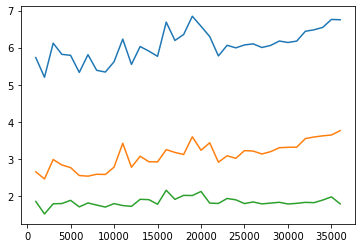

In [260]:
plt.figure()
plt.plot(taille_voc,t_nb)
plt.plot(taille_voc,t_lr)
plt.plot(taille_voc,t_svm)

In [272]:
# avec la validation croisée
def std_vc(corpus,classes,vectorizer,n_spl):
  
  accs_nb = []
  accs_lr = []
  accs_svm = []
  
  splits = []
  kf = KFold(n_splits=n_spl,shuffle=True)
  for train,test in kf.split(corpus):
    X_train,y_train = corpus[train],classes[train]
    X_test,y_test  = corpus[test],classes[test]
    sp = X_train, X_test, y_train, y_test
    splits.append(sp)
    
  for X_train, X_test, y_train, y_test in splits:

    X = vectorizer.fit_transform(X_train)

    #Naïve Bayes
    nb_clf = MultinomialNB()
    nb_clf.fit(X, y_train)


    #Logistic Regression
    lr_clf = LogisticRegression(random_state=0, solver='lbfgs',max_iter=1_000,n_jobs=-1)
    lr_clf.fit(X, y_train)

    #Linear SVM avec quelques paramètres de C
    svm_clf = LinearSVC(random_state=0, tol=1e-5)
    svm_clf.fit(X, y_train)

    X_t = vectorizer.transform(X_test)

    pred_nb = nb_clf.predict(X_t)
    pred_lr = lr_clf.predict(X_t)
    pred_svm = svm_clf.predict(X_t)
    
    accs_nb.append(accuracy_score(y_test, pred_nb))
    accs_lr.append(accuracy_score(y_test, pred_lr))
    accs_svm.append(accuracy_score(y_test, pred_svm))
    
  return np.std(accs_nb),np.std(accs_lr),np.std(accs_svm)

In [273]:
std_nb = []
std_lr = []
std_svm = []
lsplts = [i for i in range(5,21)]

vectorizer = CountVectorizer(lowercase=True)
for sp in lsplts:
  re = std_vc(alltxts,alllabs,vectorizer,sp)
  std_nb.append(re[0])
  std_lr.append(re[1])
  std_svm.append(re[2])

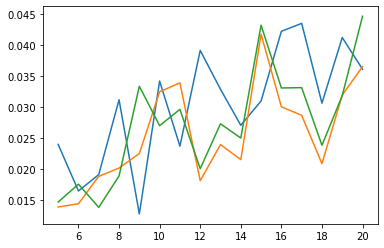

In [274]:
plt.figure()
plt.plot(lsplts,std_nb)
plt.plot(lsplts,std_lr)
plt.plot(lsplts,std_svm)